# Build CNN

## Loading image data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ZeroPadding2D, Dropout, Flatten, add, Reshape
from tensorflow.keras.layers import Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from skimage.transform import resize
#import cv2

from PIL import Image
import os
from shutil import copyfile

In [2]:
os.getcwd()
#os.chdir("/Users/qingruan/Desktop/Capstone")

'/groups/dats6501/carrieqing'

In [3]:
category_names = [
'agricultural',
    'airplane', 'baseballdiamond', 'beach', 
    'buildings', 'chaparral', 'denseresidential', 'forest', 
    'freeway', 'golfcourse', 'harbor', 'intersection', 
    'mediumresidential', 'mobilehomepark', 
    'overpass', 'parkinglot', 'river', 'runway', 
    'sparseresidential', 'storagetanks', 'tenniscourt'
]

In [4]:
num_images = 100  # per category
nb_classes = len(category_names)
patch_size = 256  # width and height in pixel
channels = 3

In [5]:
# Load the numpy datasets
images_orig = np.load('new data/UCMerced_images_orig_MultiClass21.npy')
labels_num = np.load('new data/UCMerced_labels_num_MultiClass21.npy')

# Convert labels to categorical 'one hot encoded vector' --> required format for softmax cross-entropy loss.
# Create an array of zeros with length nb_classes and put a 1 at the index of the true label.
labels = to_categorical(labels_num, nb_classes)

print('Orginal Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels_num[i])

print('One-hot encoded Labels: \n')
for i in range(1,(nb_classes)*100+1, 100):
    print(labels[i])

print('\nImages shape: {}'.format(images_orig.shape))
print('\nLabel shape: {}'.format(labels.shape))

Orginal Labels: 

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11]
[12]
[13]
[14]
[15]
[16]
[17]
[18]
[19]
[20]
One-hot encoded Labels: 

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 

In [6]:
nb_images = images_orig.shape[0]
nb_images

2100

## Train/val/test Split

In [7]:
nb_images = images_orig.shape[0]
nb_images

2100

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images_orig, labels, 
                                                    test_size=0.2, 
                                                    stratify = labels, 
                                                    random_state=2021)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.25, 
                                                  stratify = y_train,
                                                  random_state=2021) 

# 0.25 x 0.8 = 0.2

In [9]:
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape,)

(1260, 64, 64, 3) (420, 64, 64, 3) (420, 64, 64, 3) (1260, 21) (420, 21) (420, 21)


Check how many images per class in train/val/test

In [10]:
def unique_counts(arr):
    unique, counts = np.unique(arr, axis=0, return_counts=True)
    unique_num = [np.where(r==1)[0][0] for r in unique] 
    print(dict(zip(unique_num, counts)))

In [11]:
unique_counts(y_train)
unique_counts(y_val)
unique_counts(y_test)

{20: 60, 19: 60, 18: 60, 17: 60, 16: 60, 15: 60, 14: 60, 13: 60, 12: 60, 11: 60, 10: 60, 9: 60, 8: 60, 7: 60, 6: 60, 5: 60, 4: 60, 3: 60, 2: 60, 1: 60, 0: 60}
{20: 20, 19: 20, 18: 20, 17: 20, 16: 20, 15: 20, 14: 20, 13: 20, 12: 20, 11: 20, 10: 20, 9: 20, 8: 20, 7: 20, 6: 20, 5: 20, 4: 20, 3: 20, 2: 20, 1: 20, 0: 20}
{20: 20, 19: 20, 18: 20, 17: 20, 16: 20, 15: 20, 14: 20, 13: 20, 12: 20, 11: 20, 10: 20, 9: 20, 8: 20, 7: 20, 6: 20, 5: 20, 4: 20, 3: 20, 2: 20, 1: 20, 0: 20}


## Building basic CNN

### [1] Build architecture

conv1: 32*(3,3) filter, same padding, relu + maxpooling; conv2: 64*(3,3) filter, same padding, relu + maxpooling
dropout 0.5
softmax

In [12]:
# parameters:
input_shape = (64, 64, 3)
pool_size = (3, 3)                  # size of pooling area for max pooling
prob_drop_hidden = 0.5              # drop probability for dropout @ dense layer

def define_CNN_base():

    model = Sequential()

    # conv1 layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', 
                   input_shape=input_shape))    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu', ))    
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2, 2), padding='same'))
    
    # conv2 layer
    #model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1,1), padding='same', activation='relu' ))
    model.add(MaxPooling2D(pool_size=pool_size, strides=(2,2), padding='same'))

    model.add(Flatten())

    # fc1 layer
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # fc2 layer
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=prob_drop_hidden))

    # The output of the model (softmax)
    model.add(Dense(21, activation='softmax'))
    #model.add(Dense(nb_classes, activation='sigmoid'))

    return model

# clear the session first, such that layer names start with index 1
K.clear_session()
model_CNN_base = define_CNN_base()

In [13]:
model_CNN_base.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               1

### [2]Compile Model

In [14]:
# set your architecture
model = define_CNN_base()

In [15]:
# Define an optimizer
base_learning_rate=0.001

opt = Adam(lr=base_learning_rate)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])       

In [16]:
checkpoint_best_model = 'model/MultiClass_2Conv_1Conv.hdf5'

# To monitor loss, mode min and set patience to 600 
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=600)
# Use path defined above, and save best only 
mc = ModelCheckpoint(checkpoint_best_model, monitor='val_accuracy', mode='max', verbose=1, 
                     save_best_only=True)

## Train Model

In [17]:
# Set hyper parameters
epochs = 1000
batch_size = 32

In [18]:
X_train.shape,X_val.shape,y_train.shape,y_val.shape

((1260, 64, 64, 3), (420, 64, 64, 3), (1260, 21), (420, 21))

In [19]:
batches_per_epoch = y_train.shape[0]//batch_size
# the number of batches to see the full validation data:
validation_steps = y_val.shape[0]//batch_size
print('number of images per batch: {}'.format(batch_size))
print('batches per epoch: {}'.format(batches_per_epoch))
print('validation steps: {}'.format(validation_steps))

number of images per batch: 32
batches per epoch: 39
validation steps: 13


### Data augmentation

In [20]:
# Data Generator provided by keras to load the training data in batches
image_gen = ImageDataGenerator(
    #zoom_range = 0.1,
    width_shift_range=5,   # pixel
    height_shift_range=5,  # pixel
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20)

# At Test/Validation time without data augmentation
image_gen_test = ImageDataGenerator()

Total Images: 9


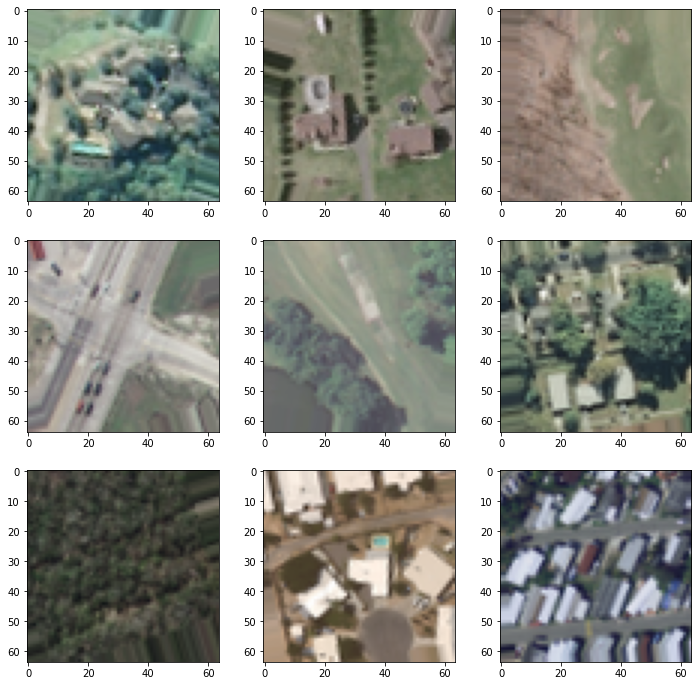

In [21]:
plt.figure(figsize=(12,12))
# configure batch size and retrieve one batch of images
for X_batch, y_batch in image_gen.flow(X_train, y_train, batch_size=9):
	# create a grid of 3x3 images
	print('Total Images:', len(X_batch))
	for i in range(0, 9):
		plt.subplot(330 + 1 + i)
		plt.imshow(X_batch[i].reshape(64, 64,3))
	# show the plot
	plt.show()
	break
    

In [22]:
train_gen = image_gen.flow(np.array(X_train),
                           y_train,
                           batch_size = batch_size,
                           shuffle = True)
val_gen = image_gen_test.flow(np.array(X_val),
                              y_val,
                              batch_size = batch_size,
                              shuffle = True)

Training commences by making a call to the fit method with our training and validation sets

In [23]:
# Fit the model parameters
print('training...')

history = model.fit(
                x=train_gen,
                steps_per_epoch=batches_per_epoch, 
                epochs=epochs, 
                validation_data=val_gen,
                validation_steps=validation_steps,
                callbacks=[es, mc],
                verbose = 2,
                )

print('done')

training...
Epoch 1/1000
39/39 - 30s - loss: 3.0834 - accuracy: 0.0464 - val_loss: 3.0445 - val_accuracy: 0.0481

Epoch 00001: val_accuracy improved from -inf to 0.04808, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 2/1000
39/39 - 30s - loss: 3.0280 - accuracy: 0.0456 - val_loss: 2.9363 - val_accuracy: 0.0481

Epoch 00002: val_accuracy did not improve from 0.04808
Epoch 3/1000
39/39 - 32s - loss: 2.9734 - accuracy: 0.0651 - val_loss: 2.8611 - val_accuracy: 0.0962

Epoch 00003: val_accuracy improved from 0.04808 to 0.09615, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 4/1000
39/39 - 31s - loss: 2.8967 - accuracy: 0.1010 - val_loss: 2.7805 - val_accuracy: 0.1370

Epoch 00004: val_accuracy improved from 0.09615 to 0.13702, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 5/1000
39/39 - 33s - loss: 2.8242 - accuracy: 0.1124 - val_loss: 2.7807 - val_accuracy: 0.1659

Epoch 00005: val_accuracy improved from 0.13702 to 0.16587, saving model to model/MultiClass_2Co


Epoch 00044: val_accuracy did not improve from 0.73077
Epoch 45/1000
39/39 - 32s - loss: 0.9948 - accuracy: 0.6531 - val_loss: 0.7821 - val_accuracy: 0.7620

Epoch 00045: val_accuracy improved from 0.73077 to 0.76202, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 46/1000
39/39 - 32s - loss: 0.9866 - accuracy: 0.6621 - val_loss: 1.0897 - val_accuracy: 0.6827

Epoch 00046: val_accuracy did not improve from 0.76202
Epoch 47/1000
39/39 - 33s - loss: 0.9987 - accuracy: 0.6718 - val_loss: 0.7890 - val_accuracy: 0.7476

Epoch 00047: val_accuracy did not improve from 0.76202
Epoch 48/1000
39/39 - 33s - loss: 0.9124 - accuracy: 0.6946 - val_loss: 1.1530 - val_accuracy: 0.6923

Epoch 00048: val_accuracy did not improve from 0.76202
Epoch 49/1000
39/39 - 32s - loss: 1.0079 - accuracy: 0.6816 - val_loss: 0.9563 - val_accuracy: 0.7188

Epoch 00049: val_accuracy did not improve from 0.76202
Epoch 50/1000
39/39 - 32s - loss: 0.9360 - accuracy: 0.6946 - val_loss: 0.8005 - val_accuracy: 0.72

39/39 - 33s - loss: 0.5463 - accuracy: 0.8184 - val_loss: 0.8642 - val_accuracy: 0.7812

Epoch 00094: val_accuracy did not improve from 0.81971
Epoch 95/1000
39/39 - 32s - loss: 0.5414 - accuracy: 0.8151 - val_loss: 0.6128 - val_accuracy: 0.8173

Epoch 00095: val_accuracy did not improve from 0.81971
Epoch 96/1000
39/39 - 32s - loss: 0.5398 - accuracy: 0.8192 - val_loss: 0.9092 - val_accuracy: 0.7716

Epoch 00096: val_accuracy did not improve from 0.81971
Epoch 97/1000
39/39 - 32s - loss: 0.5133 - accuracy: 0.8274 - val_loss: 0.5451 - val_accuracy: 0.8245

Epoch 00097: val_accuracy improved from 0.81971 to 0.82452, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 98/1000
39/39 - 33s - loss: 0.6141 - accuracy: 0.8013 - val_loss: 0.6762 - val_accuracy: 0.8005

Epoch 00098: val_accuracy did not improve from 0.82452
Epoch 99/1000
39/39 - 32s - loss: 0.5765 - accuracy: 0.8103 - val_loss: 0.7352 - val_accuracy: 0.8005

Epoch 00099: val_accuracy did not improve from 0.82452
Epoch 100/1

39/39 - 24s - loss: 0.4299 - accuracy: 0.8607 - val_loss: 0.6199 - val_accuracy: 0.8197

Epoch 00144: val_accuracy did not improve from 0.84135
Epoch 145/1000
39/39 - 24s - loss: 0.4222 - accuracy: 0.8730 - val_loss: 0.8573 - val_accuracy: 0.7909

Epoch 00145: val_accuracy did not improve from 0.84135
Epoch 146/1000
39/39 - 24s - loss: 0.3986 - accuracy: 0.8705 - val_loss: 0.6559 - val_accuracy: 0.8149

Epoch 00146: val_accuracy did not improve from 0.84135
Epoch 147/1000
39/39 - 23s - loss: 0.4348 - accuracy: 0.8428 - val_loss: 0.6809 - val_accuracy: 0.8293

Epoch 00147: val_accuracy did not improve from 0.84135
Epoch 148/1000
39/39 - 23s - loss: 0.4080 - accuracy: 0.8689 - val_loss: 0.7265 - val_accuracy: 0.8077

Epoch 00148: val_accuracy did not improve from 0.84135
Epoch 149/1000
39/39 - 23s - loss: 0.3674 - accuracy: 0.8811 - val_loss: 0.5403 - val_accuracy: 0.8510

Epoch 00149: val_accuracy improved from 0.84135 to 0.85096, saving model to model/MultiClass_2Conv_2Conv.hdf5
Epoch 


Epoch 00195: val_accuracy did not improve from 0.85096
Epoch 196/1000
39/39 - 19s - loss: 0.4066 - accuracy: 0.8648 - val_loss: 0.8894 - val_accuracy: 0.8197

Epoch 00196: val_accuracy did not improve from 0.85096
Epoch 197/1000
39/39 - 19s - loss: 0.3157 - accuracy: 0.8982 - val_loss: 0.8304 - val_accuracy: 0.8221

Epoch 00197: val_accuracy did not improve from 0.85096
Epoch 198/1000
39/39 - 19s - loss: 0.4154 - accuracy: 0.8762 - val_loss: 0.8275 - val_accuracy: 0.8149

Epoch 00198: val_accuracy did not improve from 0.85096
Epoch 199/1000
39/39 - 19s - loss: 0.3523 - accuracy: 0.8852 - val_loss: 0.8895 - val_accuracy: 0.8029

Epoch 00199: val_accuracy did not improve from 0.85096
Epoch 200/1000
39/39 - 19s - loss: 0.3304 - accuracy: 0.8974 - val_loss: 0.7227 - val_accuracy: 0.8245

Epoch 00200: val_accuracy did not improve from 0.85096
Epoch 201/1000
39/39 - 19s - loss: 0.3474 - accuracy: 0.8836 - val_loss: 0.8141 - val_accuracy: 0.8317

Epoch 00201: val_accuracy did not improve fro

Epoch 247/1000
39/39 - 19s - loss: 0.2940 - accuracy: 0.9080 - val_loss: 0.6499 - val_accuracy: 0.8245

Epoch 00247: val_accuracy did not improve from 0.85337
Epoch 248/1000
39/39 - 19s - loss: 0.2799 - accuracy: 0.9104 - val_loss: 0.6718 - val_accuracy: 0.8293

Epoch 00248: val_accuracy did not improve from 0.85337
Epoch 249/1000
39/39 - 19s - loss: 0.3249 - accuracy: 0.8990 - val_loss: 0.7985 - val_accuracy: 0.8173

Epoch 00249: val_accuracy did not improve from 0.85337
Epoch 250/1000
39/39 - 19s - loss: 0.3390 - accuracy: 0.9055 - val_loss: 0.9554 - val_accuracy: 0.8005

Epoch 00250: val_accuracy did not improve from 0.85337
Epoch 251/1000
39/39 - 19s - loss: 0.3390 - accuracy: 0.9007 - val_loss: 0.7399 - val_accuracy: 0.8269

Epoch 00251: val_accuracy did not improve from 0.85337
Epoch 252/1000
39/39 - 19s - loss: 0.2590 - accuracy: 0.9047 - val_loss: 0.8952 - val_accuracy: 0.8005

Epoch 00252: val_accuracy did not improve from 0.85337
Epoch 253/1000
39/39 - 19s - loss: 0.3200 - ac


Epoch 00298: val_accuracy did not improve from 0.85337
Epoch 299/1000
39/39 - 15s - loss: 0.2804 - accuracy: 0.9047 - val_loss: 0.8407 - val_accuracy: 0.8197

Epoch 00299: val_accuracy did not improve from 0.85337
Epoch 300/1000
39/39 - 14s - loss: 0.2818 - accuracy: 0.9023 - val_loss: 0.8007 - val_accuracy: 0.8125

Epoch 00300: val_accuracy did not improve from 0.85337
Epoch 301/1000
39/39 - 15s - loss: 0.2747 - accuracy: 0.9121 - val_loss: 1.0243 - val_accuracy: 0.8053

Epoch 00301: val_accuracy did not improve from 0.85337
Epoch 302/1000
39/39 - 15s - loss: 0.3039 - accuracy: 0.8925 - val_loss: 0.7673 - val_accuracy: 0.8125

Epoch 00302: val_accuracy did not improve from 0.85337
Epoch 303/1000
39/39 - 15s - loss: 0.2351 - accuracy: 0.9267 - val_loss: 0.7811 - val_accuracy: 0.8125

Epoch 00303: val_accuracy did not improve from 0.85337
Epoch 304/1000
39/39 - 14s - loss: 0.2535 - accuracy: 0.9235 - val_loss: 0.7124 - val_accuracy: 0.8293

Epoch 00304: val_accuracy did not improve fro


Epoch 00350: val_accuracy did not improve from 0.85337
Epoch 351/1000
39/39 - 15s - loss: 0.2041 - accuracy: 0.9349 - val_loss: 0.5743 - val_accuracy: 0.8534

Epoch 00351: val_accuracy did not improve from 0.85337
Epoch 352/1000
39/39 - 15s - loss: 0.2497 - accuracy: 0.9178 - val_loss: 0.7236 - val_accuracy: 0.8101

Epoch 00352: val_accuracy did not improve from 0.85337
Epoch 353/1000
39/39 - 15s - loss: 0.2016 - accuracy: 0.9308 - val_loss: 0.6579 - val_accuracy: 0.8486

Epoch 00353: val_accuracy did not improve from 0.85337
Epoch 354/1000
39/39 - 15s - loss: 0.2246 - accuracy: 0.9275 - val_loss: 0.7292 - val_accuracy: 0.8269

Epoch 00354: val_accuracy did not improve from 0.85337
Epoch 355/1000
39/39 - 15s - loss: 0.1934 - accuracy: 0.9365 - val_loss: 0.6881 - val_accuracy: 0.8413

Epoch 00355: val_accuracy did not improve from 0.85337
Epoch 356/1000
39/39 - 15s - loss: 0.2173 - accuracy: 0.9300 - val_loss: 0.6524 - val_accuracy: 0.8462

Epoch 00356: val_accuracy did not improve fro


Epoch 00401: val_accuracy did not improve from 0.86058
Epoch 402/1000
39/39 - 15s - loss: 0.2691 - accuracy: 0.9112 - val_loss: 0.8090 - val_accuracy: 0.8221

Epoch 00402: val_accuracy did not improve from 0.86058
Epoch 403/1000
39/39 - 15s - loss: 0.2221 - accuracy: 0.9251 - val_loss: 0.6331 - val_accuracy: 0.8486

Epoch 00403: val_accuracy did not improve from 0.86058
Epoch 404/1000
39/39 - 15s - loss: 0.2175 - accuracy: 0.9300 - val_loss: 0.9841 - val_accuracy: 0.8005

Epoch 00404: val_accuracy did not improve from 0.86058
Epoch 405/1000
39/39 - 15s - loss: 0.1991 - accuracy: 0.9446 - val_loss: 0.6674 - val_accuracy: 0.8413

Epoch 00405: val_accuracy did not improve from 0.86058
Epoch 406/1000
39/39 - 15s - loss: 0.2342 - accuracy: 0.9247 - val_loss: 0.8977 - val_accuracy: 0.7957

Epoch 00406: val_accuracy did not improve from 0.86058
Epoch 407/1000
39/39 - 15s - loss: 0.2787 - accuracy: 0.9161 - val_loss: 1.1096 - val_accuracy: 0.8101

Epoch 00407: val_accuracy did not improve fro

39/39 - 14s - loss: 0.2334 - accuracy: 0.9300 - val_loss: 0.8243 - val_accuracy: 0.8221

Epoch 00453: val_accuracy did not improve from 0.86298
Epoch 454/1000
39/39 - 15s - loss: 0.2016 - accuracy: 0.9446 - val_loss: 0.9993 - val_accuracy: 0.7981

Epoch 00454: val_accuracy did not improve from 0.86298
Epoch 455/1000
39/39 - 15s - loss: 0.2149 - accuracy: 0.9373 - val_loss: 0.6829 - val_accuracy: 0.8341

Epoch 00455: val_accuracy did not improve from 0.86298
Epoch 456/1000
39/39 - 14s - loss: 0.2552 - accuracy: 0.9226 - val_loss: 0.8357 - val_accuracy: 0.8221

Epoch 00456: val_accuracy did not improve from 0.86298
Epoch 457/1000
39/39 - 15s - loss: 0.1484 - accuracy: 0.9511 - val_loss: 1.0220 - val_accuracy: 0.8149

Epoch 00457: val_accuracy did not improve from 0.86298
Epoch 458/1000
39/39 - 14s - loss: 0.2629 - accuracy: 0.9316 - val_loss: 0.8426 - val_accuracy: 0.8125

Epoch 00458: val_accuracy did not improve from 0.86298
Epoch 459/1000
39/39 - 14s - loss: 0.2949 - accuracy: 0.9161 


Epoch 00504: val_accuracy did not improve from 0.86779
Epoch 505/1000
39/39 - 15s - loss: 0.1866 - accuracy: 0.9454 - val_loss: 0.8657 - val_accuracy: 0.8413

Epoch 00505: val_accuracy did not improve from 0.86779
Epoch 506/1000
39/39 - 15s - loss: 0.1777 - accuracy: 0.9446 - val_loss: 0.7783 - val_accuracy: 0.8510

Epoch 00506: val_accuracy did not improve from 0.86779
Epoch 507/1000
39/39 - 15s - loss: 0.1715 - accuracy: 0.9511 - val_loss: 1.0735 - val_accuracy: 0.8101

Epoch 00507: val_accuracy did not improve from 0.86779
Epoch 508/1000
39/39 - 15s - loss: 0.1393 - accuracy: 0.9585 - val_loss: 0.8165 - val_accuracy: 0.8510

Epoch 00508: val_accuracy did not improve from 0.86779
Epoch 509/1000
39/39 - 15s - loss: 0.2012 - accuracy: 0.9463 - val_loss: 0.7107 - val_accuracy: 0.8341

Epoch 00509: val_accuracy did not improve from 0.86779
Epoch 510/1000
39/39 - 15s - loss: 0.2856 - accuracy: 0.9194 - val_loss: 0.7427 - val_accuracy: 0.8365

Epoch 00510: val_accuracy did not improve fro


Epoch 00556: val_accuracy did not improve from 0.86779
Epoch 557/1000
39/39 - 15s - loss: 0.1547 - accuracy: 0.9552 - val_loss: 1.0433 - val_accuracy: 0.8053

Epoch 00557: val_accuracy did not improve from 0.86779
Epoch 558/1000
39/39 - 15s - loss: 0.2065 - accuracy: 0.9414 - val_loss: 0.9113 - val_accuracy: 0.8389

Epoch 00558: val_accuracy did not improve from 0.86779
Epoch 559/1000
39/39 - 15s - loss: 0.2216 - accuracy: 0.9349 - val_loss: 1.0984 - val_accuracy: 0.8125

Epoch 00559: val_accuracy did not improve from 0.86779
Epoch 560/1000
39/39 - 15s - loss: 0.2108 - accuracy: 0.9324 - val_loss: 0.9761 - val_accuracy: 0.8173

Epoch 00560: val_accuracy did not improve from 0.86779
Epoch 561/1000
39/39 - 15s - loss: 0.1989 - accuracy: 0.9463 - val_loss: 1.0755 - val_accuracy: 0.8053

Epoch 00561: val_accuracy did not improve from 0.86779
Epoch 562/1000
39/39 - 15s - loss: 0.2546 - accuracy: 0.9430 - val_loss: 1.0289 - val_accuracy: 0.8293

Epoch 00562: val_accuracy did not improve fro


Epoch 00608: val_accuracy did not improve from 0.86779
Epoch 609/1000
39/39 - 15s - loss: 0.1489 - accuracy: 0.9617 - val_loss: 0.8372 - val_accuracy: 0.8438

Epoch 00609: val_accuracy did not improve from 0.86779
Epoch 610/1000
39/39 - 15s - loss: 0.2066 - accuracy: 0.9503 - val_loss: 0.9068 - val_accuracy: 0.8341

Epoch 00610: val_accuracy did not improve from 0.86779
Epoch 611/1000
39/39 - 14s - loss: 0.1603 - accuracy: 0.9577 - val_loss: 0.9663 - val_accuracy: 0.8486

Epoch 00611: val_accuracy did not improve from 0.86779
Epoch 612/1000
39/39 - 14s - loss: 0.1756 - accuracy: 0.9471 - val_loss: 1.2586 - val_accuracy: 0.7885

Epoch 00612: val_accuracy did not improve from 0.86779
Epoch 613/1000
39/39 - 15s - loss: 0.1653 - accuracy: 0.9463 - val_loss: 0.8812 - val_accuracy: 0.8293

Epoch 00613: val_accuracy did not improve from 0.86779
Epoch 614/1000
39/39 - 14s - loss: 0.1662 - accuracy: 0.9552 - val_loss: 0.9763 - val_accuracy: 0.8101

Epoch 00614: val_accuracy did not improve fro


Epoch 00660: val_accuracy did not improve from 0.86779
Epoch 661/1000
39/39 - 14s - loss: 0.1761 - accuracy: 0.9422 - val_loss: 0.9968 - val_accuracy: 0.8389

Epoch 00661: val_accuracy did not improve from 0.86779
Epoch 662/1000
39/39 - 15s - loss: 0.1543 - accuracy: 0.9601 - val_loss: 0.9197 - val_accuracy: 0.8293

Epoch 00662: val_accuracy did not improve from 0.86779
Epoch 663/1000
39/39 - 14s - loss: 0.1307 - accuracy: 0.9650 - val_loss: 0.9146 - val_accuracy: 0.8413

Epoch 00663: val_accuracy did not improve from 0.86779
Epoch 664/1000
39/39 - 15s - loss: 0.1742 - accuracy: 0.9463 - val_loss: 0.9579 - val_accuracy: 0.8389

Epoch 00664: val_accuracy did not improve from 0.86779
Epoch 665/1000
39/39 - 15s - loss: 0.1395 - accuracy: 0.9634 - val_loss: 1.0355 - val_accuracy: 0.8389

Epoch 00665: val_accuracy did not improve from 0.86779
Epoch 666/1000
39/39 - 15s - loss: 0.1167 - accuracy: 0.9601 - val_loss: 0.9832 - val_accuracy: 0.8486

Epoch 00666: val_accuracy did not improve fro


Epoch 00712: val_accuracy did not improve from 0.86779
Epoch 713/1000
39/39 - 14s - loss: 0.1529 - accuracy: 0.9552 - val_loss: 0.8336 - val_accuracy: 0.8389

Epoch 00713: val_accuracy did not improve from 0.86779
Epoch 00713: early stopping
done


Plotting training accuracy/loss curves

In [24]:
def history_plot(model_id, history):
	plt.figure(figsize=(8,10)) 
	# plot loss
	plt.subplot(2, 1, 1)
	plt.title('Cross Entropy Loss - ' + model_id, fontsize = 12)
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='val')
	plt.xlabel("Epochs",fontsize = 12)
	plt.ylabel("Loss", fontsize = 12)
	plt.legend(loc='upper right')

	# plot accuracy
	plt.subplot(2, 1, 2)
	plt.title('Classification Accuracy ' + model_id, fontsize = 10)
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='val')
	plt.xlabel("Epochs", fontsize = 12)
	plt.ylabel("Accuracy", fontsize = 12)
	plt.legend(loc='lower right')

	plt.show()

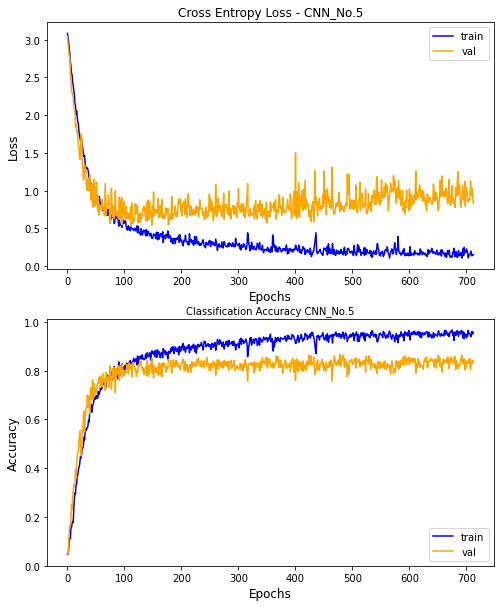

In [25]:
history_plot('CNN_No.5', history)

#### Saving our model to disk

A Keras model consists of multiple components:

+ An architecture, or configuration, which specifies what layers the model contain, and how they're connected.
+ A set of weights values (the "state of the model").
+ An optimizer (defined by compiling the model).
+ A set of losses and metrics (defined by compiling the model or calling add_loss() or add_metric()).
The Keras API makes it possible to save all of these pieces to disk at once, or to only selectively save some of them:

+ Saving everything into a single archive in the TensorFlow SavedModel format (or in the older Keras H5 format). This is the standard practice.
+ Saving the architecture / configuration only, typically as a JSON file.
+ Saving the weights values only. This is generally used when training the model.

In [26]:
saved_model = load_model(checkpoint_best_model)

from datetime import datetime
DTime = datetime.now().strftime('%Y%m%d_%H%M%S')

_, acc = saved_model.evaluate(X_train, y_train, verbose=0)
print('Model evaluate on train, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_val, y_val, verbose=0)
print('Model evaluate on val, Accuracy %.3f' % (acc * 100.0))
_, acc = saved_model.evaluate(X_test, y_test, verbose=0)
print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))
acc_test = round(100*acc,2)

save_file = checkpoint_best_model[0:-5] +'_' + DTime + '_ACC' + str(acc_test)+'.h5'
print("Model saved: ", save_file)
saved_model.save(save_file,  save_format="h5")

Model evaluate on train, Accuracy 99.841
Model evaluate on val, Accuracy 86.905
Model evaluate on test, Accuracy 83.810
Model saved:  model/MultiClass_2Conv_2Conv_20210227_034907_ACC83.81.h5


overfitting 

### Predict test data

In [27]:
# load the weights form the best epoch
model = saved_model
test_gen = image_gen_test.flow(np.array(X_test),
                              batch_size = batch_size,
                              shuffle = False)
STEP_SIZE_TEST = X_test.shape[0] // batch_size
print('predicting...')
predictions = model.predict(test_gen, 
                            steps = STEP_SIZE_TEST+1)

# convert predictions    
print('num. predictions: ', len(predictions))

predicting...
num. predictions:  420


In [28]:
y_pred = to_categorical(np.argmax(predictions, axis=1), nb_classes)

In [29]:
_, acc = model.evaluate(X_test, y_test, verbose=0)
print('Model evaluate on test, Accuracy %.3f' % (acc * 100.0))
acc_test = round(100*acc,2)

Model evaluate on test, Accuracy 83.810
